# Tutorial - Introduction to circular data analysis

When constructing a machine learning model, a model is trained using a dataset, which consists of a set of input variables and corresponding output variables. The input variables, also known as features, are used as inputs to the model, and the model learns to map these inputs to the output variables, also known as labels. The goal of training a model is to find the best set of parameters that produce the desired mapping between inputs and outputs.

In several applications, the inputs of the model consist in descriptive information of a user, a transaction, a login, among others. In most of these scenarios, there is information about the timestamp, might be time of the event, day of the week, or day of the month.
If the goal is to predict an event based on past events, you can use timestamps as input features. For example, you could use the time of day, day of the week, or month of the year as input features to a model that predicts traffic volume or energy consumption.

However, the best approach for dealing with time in a machine learning problem will depend on the specific problem you're trying to solve and the structure of your data.

In this tutorial, we show how to analyze timestamps as circular variables, and how to generate an approximate distribution that can be used as part of the feature engineering step in a building a machine learning model.


In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.insert(0, '../..')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import circular

In [4]:
from circular.training import train_time_periodic
from circular.utils import freq_time, date2rad, _date2rad
from circular.stats import kuiper_two, periodic_mean_std, von_mises_distribution
from circular.plots import base_periodic_fig, plot_CDF_kernel, clock_vonmises_distribution, plot_kernel
from circular.circular import kernel

### Read and process transactions dataset

In [5]:
df = circular.datasets.load_transactions()['data']
df['date']= pd.to_datetime(df['date'])
dates = df.loc[df['user'] == 1, 'date']

In [6]:
dates.head()

1    2020-01-01 03:09:57
6    2020-01-01 16:37:52
9    2020-01-01 19:16:12
12   2020-01-01 19:16:58
15   2020-01-01 19:17:48
Name: date, dtype: datetime64[ns]

Analysis of the transactional dates using traditional data analysis

In [7]:
dates.describe(datetime_is_numeric=True)

count                              349
mean     2020-04-03 01:32:31.352435712
min                2020-01-01 03:09:57
25%                2020-02-09 08:44:55
50%                2020-03-27 01:00:01
75%                2020-05-25 00:36:32
max                2020-07-29 22:39:35
Name: date, dtype: object

<AxesSubplot:xlabel='date'>

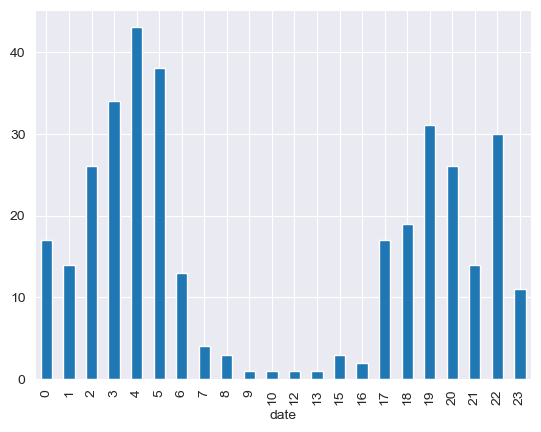

In [8]:
dates.groupby(dates.dt.hour).count().plot(kind="bar")

When dealing with hour of the day as a scalar variable, there are a few issues that can arise.

One issue is that hour of the day is cyclical in nature, meaning that the value at the end of the day (23:00) is related to the value at the beginning of the day (00:00). However, when hour of the day is treated as a scalar variable, this cyclical relationship is not taken into account, which can lead to inaccurate or misleading results.

Another issue is that hour of the day is often correlated with other variables, such as day of the week or season. For example, there may be more traffic during rush hour on a weekday than on a weekend. However, when hour of the day is treated as a scalar variable, these correlations are not taken into account and can lead to biased or misleading results.

A third issue is that hour of the day can be affected by different factors such as season, day of the week, or even holidays. These factors can greatly impact the behavior and patterns of hour of the day. So, if this information is not taken into account when using hour of the day as a scalar variable, it can lead to inaccurate conclusions.

To overcome these issues, one solution is to use a cyclical encoding technique, such as sine and cosine encoding, to incorporate the cyclical nature of the data. Another solution is to include other relevant variables, such as day of the week or season, in the model to account for potential correlations. Additionally, it's important to consider the impact of different factors on hour of the day when analyzing data.

## Plot histogram as a circular variable

We can model the time of the day as a circular variable, for that, we must first convert the time of day into radians and then plot in a 24h clock

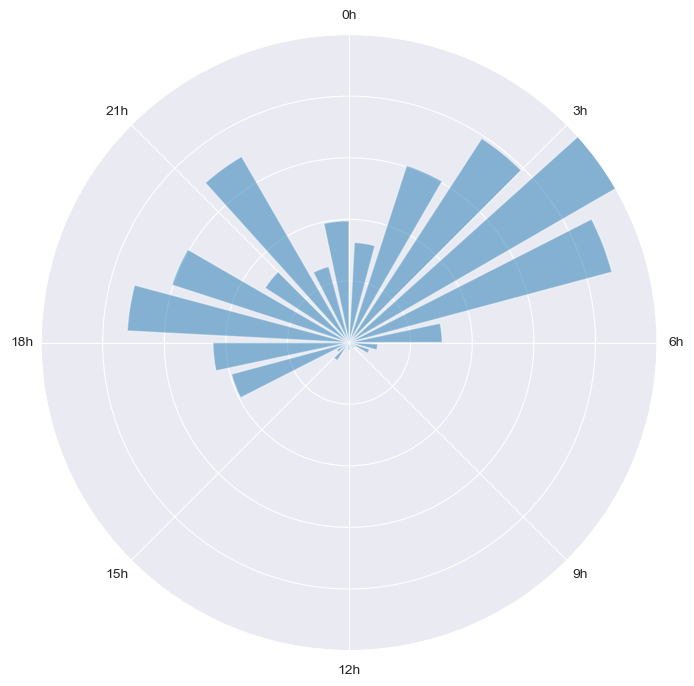

In [9]:
time_segment = 'hour'  # 'hour', 'dayweek', 'daymonth
freq_arr, times = freq_time(dates , time_segment=time_segment)
fig, ax1 = base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)

We could now create variables such as the mean time of the transaction and the standard deviation of the time of the transaction.

<BarContainer object of 1 artists>

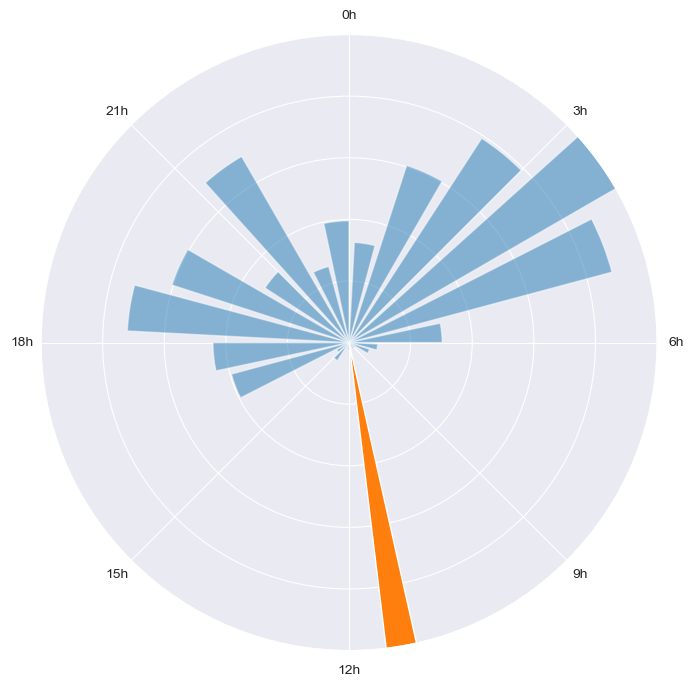

In [10]:
dates_mean = times.values.mean()

fig, ax1 = base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.bar([dates_mean], [1], width=0.1)

The issue when dealing with the time of the transaction, specifically, when analyzing a feature such as the mean of transactions time, is that it is easy to make the mistake of using the arithmetic mean. Indeed, the arithmetic mean is not a correct way to average time because, as shown in Fig. 1, it does not take into account the periodic behavior of the time feature. For example, the arithmetic mean of transaction time of four transactions made at 2:00, 3:00, 22:00 and 23:00 is 12:30, which is counter-intuitive since no transaction was made close to that time.

## Circular Analysis

We propose to overcome this limitation by modeling the time of the transaction as a periodic variable, in particular using the von Mises distribution Fisher1996. The von Mises distribution, also known as the periodic normal distribution, is a distribution of a wrapped normal distributed variable across a circle. The von Mises distribution of a set of examples
$$ D=\{t_1,t_2,\cdots,t_N\}$$  is defined as
  \begin{equation}
  D \sim vonmises\left( \mu_{vM} , \frac{1}{\sigma_{vM}} \right),
  \end{equation}
  where $\mu_{vM}$ and $\sigma_{vM}$ are the periodic mean and periodic standard deviation, respectively. In #cite (https://albahnsen.github.io/files/Feature%20Engineering%20Strategies%20for%20Credit%20Card%20Fraud%20Detection_published.pdf) we present the calculation of $\mu_{vM}$ and $\sigma_{vM}$.

<BarContainer object of 1 artists>

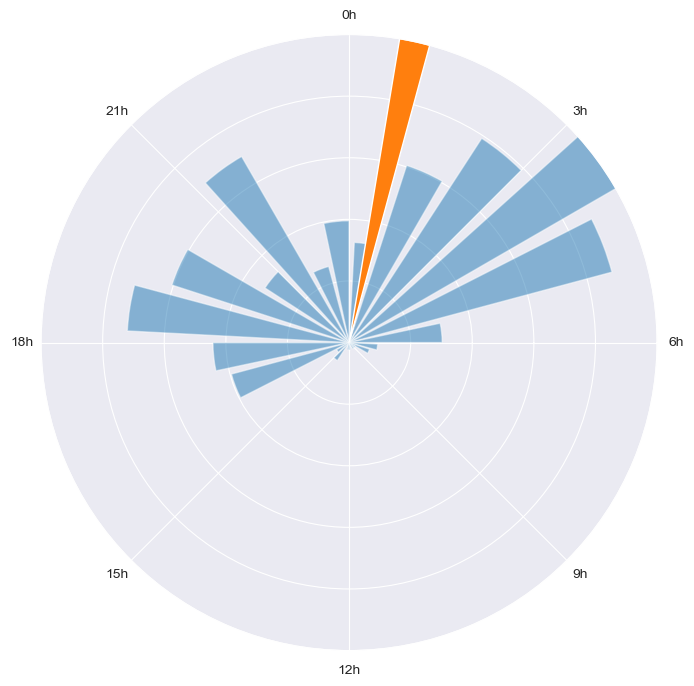

In [11]:
radians = _date2rad(dates, time_segment='hour')
mean, std = periodic_mean_std(radians)

fig, ax1 = base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.bar([mean], [1], width=0.1)

Using the circular mean and std we can calculate de von mises distribution

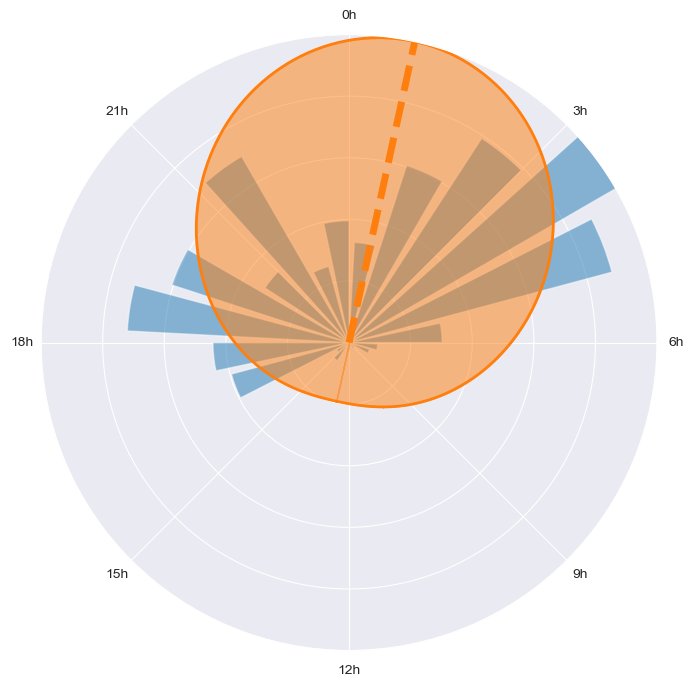

In [12]:
# Calculate the von Mises distribution
x, p = von_mises_distribution(mean, std)

fig, ax1 = base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment='hour')

ax1 = clock_vonmises_distribution(ax1, mean, x, p)

This method give us a good approximation of the distribution of the time of the events. However, when using a statistical distribution with only one mode, it may be difficult to accurately model the data if the distribution is not a good fit for the data set. Additionally, if the data set is multi-modal (i.e. has multiple peaks), a single mode distribution will not be able to capture all the variations in the data. This could lead to poor predictions or inferences based on the model.

This can be overcome by modeling the data with a von Mises kernel distribution.


## Modeling using a von Mises kernel distribution

One way to overcome the issues of using a statistical distribution with only one mode is to use a kernel-based method, such as kernel density estimation (KDE).

KDE is a non-parametric method for estimating the probability density function (PDF) of a random variable. It works by replacing the point-mass at each data point with a smooth and symmetric kernel function, such as a von Mises. The resulting estimate of the PDF is a sum of the kernel functions centered at each data point.

By using a kernel function, KDE is able to smooth out any single-modal distributions, and can capture multiple modes in the data, making it a more flexible method for modeling multi-modal data sets. Additionally, kernel density estimation is non-parametric, which means it does not make any assumptions about the underlying distribution of the data.

However, it's worth noting that choosing the right kernel is important, and there are some challenges when working with KDE such as the choice of bandwidth and the curse of dimensionality.

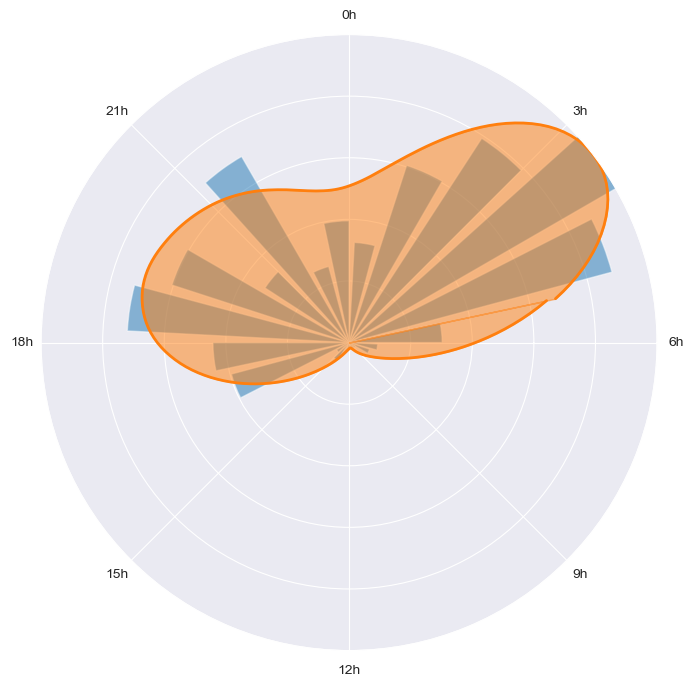

In [13]:
y = kernel(radians.values)

fig, ax1 = plot_kernel(freq_arr[:, 0], freq_arr[:, 1], y,time_segment=time_segment)

In summary, using a kernel-based method such as KDE with von Mises can help overcome the issues of using a statistical distribution with only one mode by allowing for a more flexible and robust modeling of multi-modal data sets.

### Next Steps

- In this simple example we used the predefined bandwith parameter (bw), however, selecting the right bw is a complex task. pycircular incorporates a series of optimization methods to select the best bw of a given dataset.
- It is also important to evaluate the accuracy of the kernel.
- Lastly, how can the kernel be used to create features in a machine learning model?

We will be showing how to deal with these issues in a following tutorial.
